In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import colormaps  
import json


In [2]:
movements_path = "/root/capsule/scratch/all_tongue_movements/all_tongue_movements_05112025.parquet"
all_tongue_movements = pd.read_parquet(movements_path)


In [9]:
all_tongue_movements.columns

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'out_duration', 'out_peak_velocity',
       'out_mean_velocity', 'out_total_distance', 'n_datapoints',
       'dropped_frames_n', 'dropped_frames_pct', 'has_lick',
       'first_lick_index', 'lick_count', 'trial', 'cue_response', 'rewarded',
       'event', 'lick_time', 'goCue_start_time_in_session',
       'movement_number_in_trial', 'cue_response_movement_number',
       'movement_before_cue_response', 'movement_latency_from_go',
       'lick_latency', 'session'],
      dtype='object')

Filtered from 177219 → 175090 points
Color limits (out_peak_velocity): 120, 8.4e+03


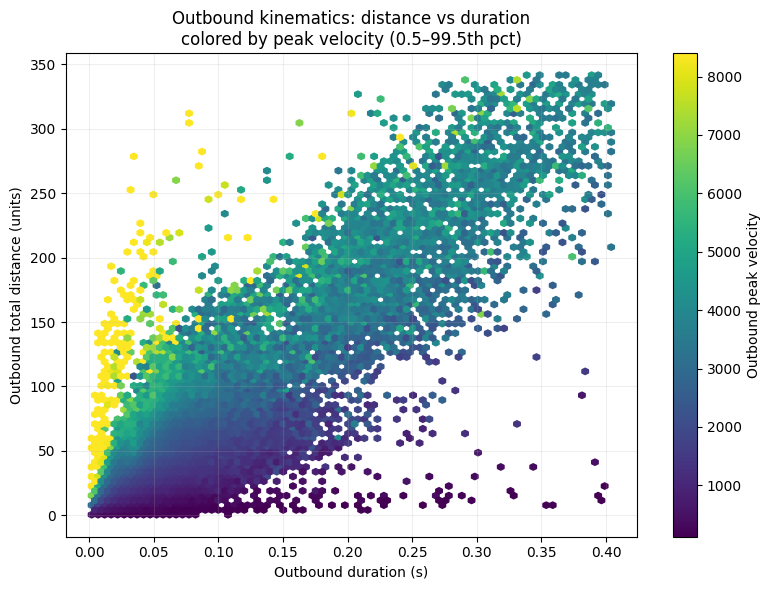

In [8]:

df = all_tongue_movements.copy()

# Keep only rows with outbound fields present
df = df.dropna(subset=["out_peak_velocity", "out_duration", "out_total_distance"])

# Percentile limits for filtering (robust to tails)
percentiles = (0.5, 99.5)
limits = {
    "out_duration":       np.nanpercentile(df["out_duration"], percentiles),
    "out_total_distance": np.nanpercentile(df["out_total_distance"], percentiles),
    "out_peak_velocity":  np.nanpercentile(df["out_peak_velocity"], percentiles),
}

# Filter outliers using outbound duration & distance
mask = (
    df["out_duration"].between(*limits["out_duration"]) &
    df["out_total_distance"].between(*limits["out_total_distance"])
)
df_f = df.loc[mask]

# Color scaling based on outbound peak velocity
vmin, vmax = limits["out_peak_velocity"]

print(f"Filtered from {len(df)} → {len(df_f)} points")
print(f"Color limits (out_peak_velocity): {vmin:.3g}, {vmax:.3g}")

# Plot: duration (x) vs distance (y), color by peak velocity
fig, ax = plt.subplots(figsize=(8, 6))
hb = ax.hexbin(
    df_f["out_duration"].to_numpy(),
    df_f["out_total_distance"].to_numpy(),
    C=df_f["out_peak_velocity"].to_numpy(),
    reduce_C_function=np.mean,
    gridsize=80,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)

cbar = plt.colorbar(hb, ax=ax, label="Outbound peak velocity")
ax.set_xlabel("Outbound duration (s)")
ax.set_ylabel("Outbound total distance (units)")
ax.set_title(f"Outbound kinematics: distance vs duration\ncolored by peak velocity ({percentiles[0]}–{percentiles[1]}th pct)")
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


Filtered from 177219 → 168406 points


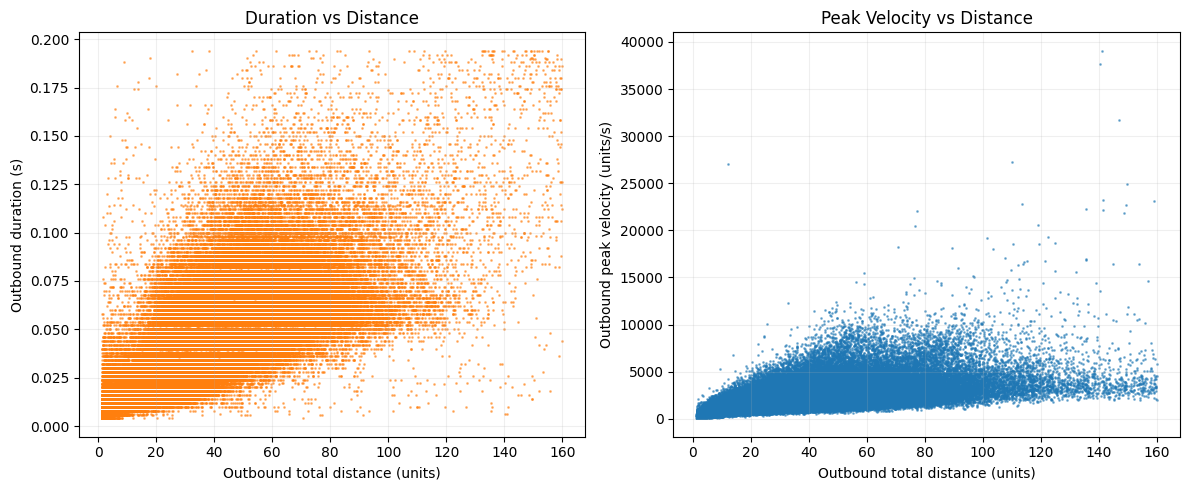

In [4]:
import numpy as np
import matplotlib.pyplot as plt

df = all_tongue_movements.copy()

# Keep only rows with outbound fields present
df = df.dropna(subset=["out_peak_velocity", "out_duration", "out_total_distance"])

# Percentile limits for filtering (robust to tails)
percentiles = (2, 98)
limits = {
    "out_duration":       np.nanpercentile(df["out_duration"], percentiles),
    "out_total_distance": np.nanpercentile(df["out_total_distance"], percentiles),
    "out_peak_velocity":  np.nanpercentile(df["out_peak_velocity"], percentiles),
}

# Filter outliers using outbound duration & distance
mask = (
    df["out_duration"].between(*limits["out_duration"]) &
    df["out_total_distance"].between(*limits["out_total_distance"])
)
df_f = df.loc[mask]

print(f"Filtered from {len(df)} → {len(df_f)} points")

# --- Plot setup ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Panel 1: Duration vs Distance
axes[0].scatter(
    df_f["out_total_distance"],
    df_f["out_duration"],
    s=1, alpha=0.5, color="tab:orange"
)
axes[0].set_xlabel("Outbound total distance (units)")
axes[0].set_ylabel("Outbound duration (s)")
axes[0].set_title("Duration vs Distance")

# Panel 2: Peak Velocity vs Distance
axes[1].scatter(
    df_f["out_total_distance"],
    df_f["out_peak_velocity"],
    s=1, alpha=0.5, color="tab:blue"
)
axes[1].set_xlabel("Outbound total distance (units)")
axes[1].set_ylabel("Outbound peak velocity (units/s)")
axes[1].set_title("Peak Velocity vs Distance")

# Common formatting
for ax in axes:
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


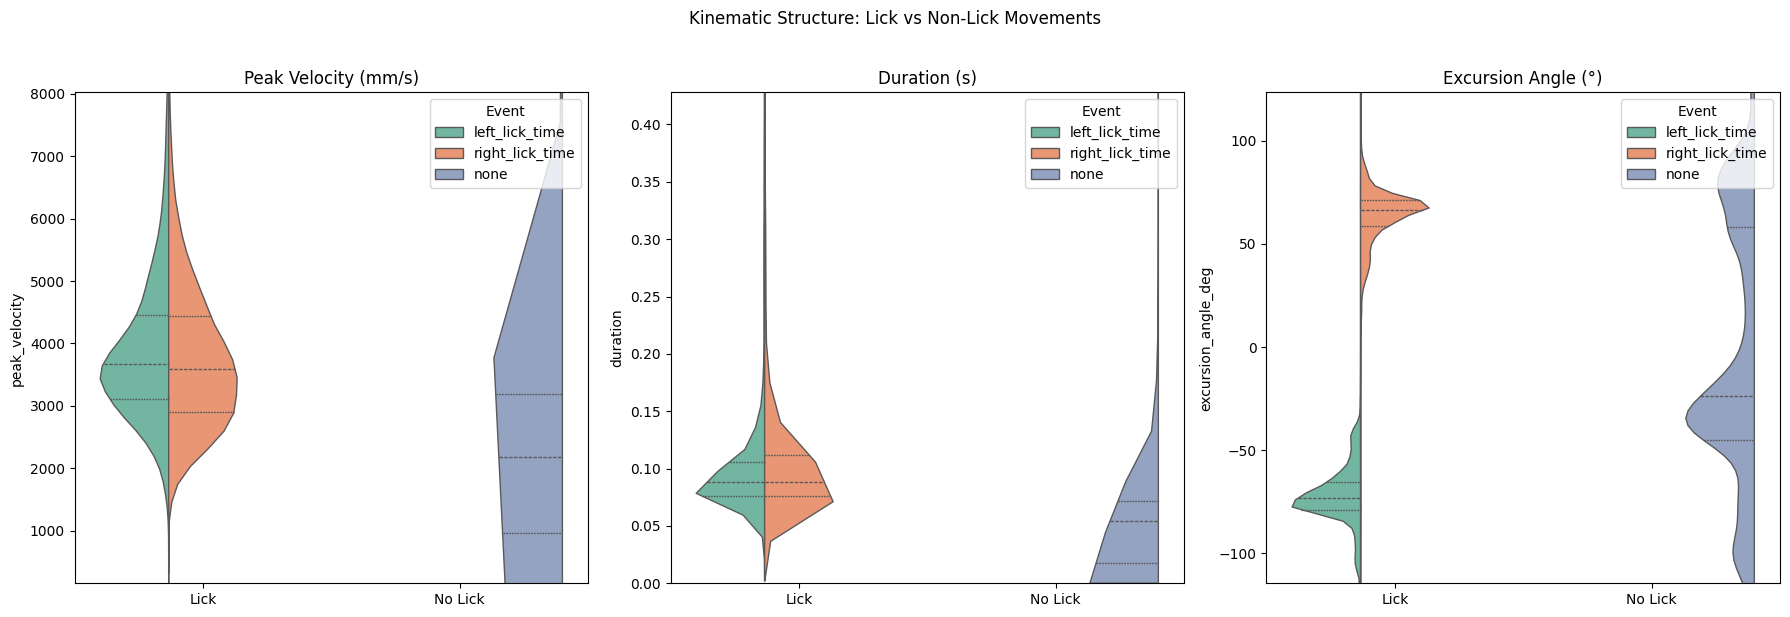

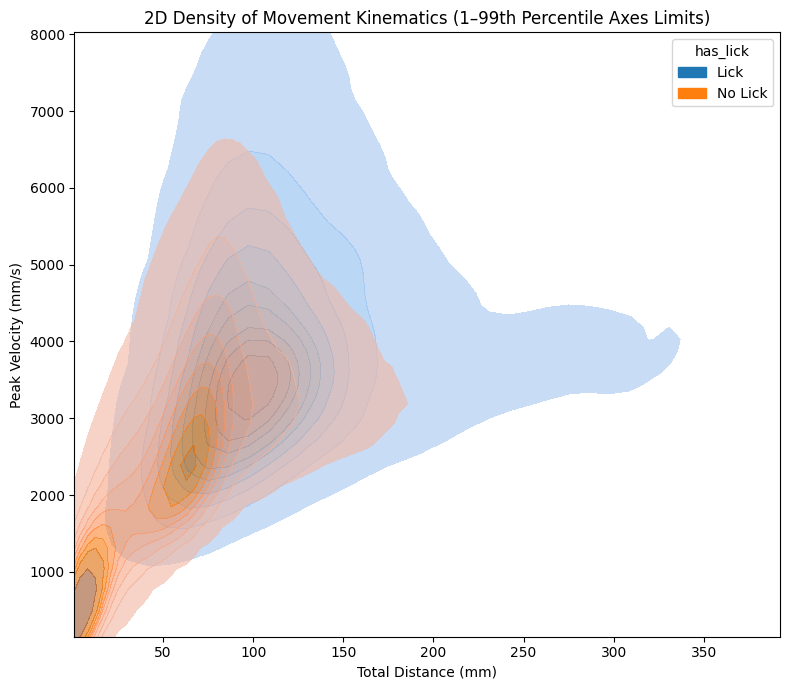

In [5]:


# --- Prepare data ---
df_plot = all_tongue_movements.copy()
df_plot["has_lick"] = df_plot["has_lick"].map({True: "Lick", False: "No Lick"}).astype("category")
df_plot["event"] = df_plot["event"].fillna("none")


# === Compute percentile-based axis limits (without modifying data) ===
def get_axis_limits(df, cols, low=1, high=99):
    limits = {}
    for col in cols:
        lo, hi = np.nanpercentile(df[col], [low, high])
        limits[col] = (lo, hi)
    return limits

limits = get_axis_limits(df_plot,
                         ["peak_velocity", "duration", "excursion_angle_deg", "total_distance"],
                         low=1, high=99)

# --- 1️⃣ Violin plots: peak_velocity, duration, excursion_angle_deg ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
features = ["peak_velocity", "duration", "excursion_angle_deg"]
titles = ["Peak Velocity (mm/s)", "Duration (s)", "Excursion Angle (°)"]

for ax, feat, title in zip(axes, features, titles):
    sns.violinplot(data=df_plot, x="has_lick", y=feat, hue="event",
                   split=True, inner="quart", linewidth=1,
                   palette="Set2", ax=ax, cut=0)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.legend(title="Event", loc="upper right")
    # Apply percentile-based y-axis limits
    ax.set_ylim(limits[feat])
plt.suptitle("Kinematic Structure: Lick vs Non-Lick Movements", y=1.02)
plt.tight_layout()

# --- 2️⃣ 2D Density Plot: peak_velocity vs total_distance ---
plt.figure(figsize=(8, 7))
sns.kdeplot(
    data=df_plot, x="total_distance", y="peak_velocity",
    hue="has_lick", fill=True, common_norm=False,
    alpha=0.6, thresh=0.05
)
plt.xlabel("Total Distance (mm)")
plt.ylabel("Peak Velocity (mm/s)")
plt.xlim(limits["total_distance"])
plt.ylim(limits["peak_velocity"])
plt.title("2D Density of Movement Kinematics (1–99th Percentile Axes Limits)")
plt.tight_layout()
plt.show()


In [3]:
# trimming to endpoints


def aggregate_tongue_movements_outbound(tongue_segmented: pd.DataFrame,
                               keypoint_dfs_trimmed: dict) -> pd.DataFrame:
    """
    Aggregate kinematic, lick, and frame-level features of tongue movements.
    Adds outbound-only metrics computed up to the endpoint (max dist from jaw):
      - out_duration, out_peak_velocity, out_mean_velocity, out_total_distance
    """


    required = {"movement_id", "time_in_session", "x", "y", "v",
                "xv", "yv", "lick", "lick_index", "trial"}
    if not required.issubset(tongue_segmented.columns):
        missing = required - set(tongue_segmented.columns)
        raise ValueError(f"Missing columns in tongue_segmented: {missing}")

    # 1) Core kinematic metrics (full segment)
    movement_metrics = tongue_segmented.groupby("movement_id").agg(
        start_time=("time_in_session", "min"),
        end_time=("time_in_session", "max"),
        duration=("time_in_session", lambda x: x.max() - x.min()),
        min_x=("x", "min"), max_x=("x", "max"),
        min_y=("y", "min"), max_y=("y", "max"),
        min_xv=("xv", "min"), max_xv=("xv", "max"),
        min_yv=("yv", "min"), max_yv=("yv", "max"),
        peak_velocity=("v", "max"), mean_velocity=("v", "mean")
    )

    # Sort once for all per-movement computations
    tongue_sorted = tongue_segmented.sort_values(["movement_id", "time_in_session"])

    # 2) Total distance (full segment)
    distances = []
    for mid, grp in tongue_sorted.groupby("movement_id"):
        g = grp.dropna(subset=["x", "y"]).reset_index(drop=True)
        if len(g) < 2:
            distances.append((mid, np.nan))
        else:
            d = np.sqrt(np.diff(g["x"])**2 + np.diff(g["y"])**2).sum()
            distances.append((mid, d))
    movement_distances = pd.DataFrame(
        distances, columns=["movement_id", "total_distance"]
    ).set_index("movement_id")

    # 3) Excursions (endpoint) + OUTBOUND-ONLY metrics (computed right here)
    jaw_mean = keypoint_dfs_trimmed['jaw'][['x', 'y']].mean()
    jx, jy = jaw_mean['x'], jaw_mean['y']

    excursions = []
    outbound_rows = []  # will hold outbound-only summary per movement

    for mid, grp in tongue_sorted.groupby("movement_id"):
        grp = grp.dropna(subset=["x", "y"]).reset_index(drop=True)
        if grp.empty:
            # still record empties to keep alignment
            excursions.append({
                "movement_id": mid,
                "startpoint_x": np.nan, "startpoint_y": np.nan,
                "endpoint_x": np.nan, "endpoint_y": np.nan,
                "time_to_endpoint": np.nan, "excursion_angle_deg": np.nan,
                "max_x_from_jaw": np.nan, "max_x_from_jaw_y": np.nan,
                "max_y_from_jaw": np.nan, "max_y_from_jaw_x": np.nan,
                "max_x_distance": np.nan, "max_y_distance": np.nan
            })
            outbound_rows.append({
                "movement_id": mid,
                "out_duration": np.nan,
                "out_peak_velocity": np.nan,
                "out_mean_velocity": np.nan,
                "out_total_distance": np.nan
            })
            continue

        # start
        sx, sy = grp.loc[0, ["x", "y"]]

        # endpoint = furthest Euclidean from jaw
        ed = np.sqrt((grp["x"] - jx)**2 + (grp["y"] - jy)**2)
        idx = ed.idxmax(); row = grp.loc[idx]
        ex, ey = row["x"], row["y"]
        tt = row["time_in_session"] - grp.loc[0, "time_in_session"]
        angle = np.degrees(np.arctan2(ey - jy, ex - jx))

        # max x and y distances separately (still full segment)
        dx = (grp["x"] - jx); idx_x = dx.idxmax()
        dy_abs = (grp["y"] - jy).abs(); idx_y = dy_abs.idxmax()

        excursions.append({
            "movement_id": mid,
            "startpoint_x": sx, "startpoint_y": sy,
            "endpoint_x": ex, "endpoint_y": ey,
            "time_to_endpoint": tt, "excursion_angle_deg": angle,
            "max_x_from_jaw": grp.loc[idx_x, "x"], "max_x_from_jaw_y": grp.loc[idx_x, "y"],
            "max_y_from_jaw": grp.loc[idx_y, "y"], "max_y_from_jaw_x": grp.loc[idx_y, "x"],
            "max_x_distance": abs(grp.loc[idx_x, "x"] - jx),
            "max_y_distance": abs(grp.loc[idx_y, "y"] - jy)
        })

        # === OUTBOUND-ONLY slice: frames up to and including endpoint idx ===
        kept = grp.iloc[: idx + 1].copy()
        if len(kept) < 2:
            out_dist = np.nan
        else:
            out_dist = float(np.sqrt(np.diff(kept["x"])**2 + np.diff(kept["y"])**2).sum())

        out_duration = float(kept["time_in_session"].iloc[-1] - kept["time_in_session"].iloc[0])
        out_peak = float(kept["v"].max()) if "v" in kept.columns else np.nan
        out_mean = float(kept["v"].mean()) if "v" in kept.columns else np.nan

        outbound_rows.append({
            "movement_id": mid,
            "out_duration": out_duration,
            "out_peak_velocity": out_peak,
            "out_mean_velocity": out_mean,
            "out_total_distance": out_dist
        })

    excursions = pd.DataFrame(excursions).set_index("movement_id")
    outbound_df = pd.DataFrame(outbound_rows).set_index("movement_id")

    # 4) Frame-level stats (full segment)
    frame_stats = tongue_segmented.groupby("movement_id").agg(
        n_datapoints=("x", lambda s: s.notna().sum()),
        dropped_frames_n=("x", lambda s: s.isna().sum())
    )
    frame_stats['dropped_frames_pct'] = (
        100 * frame_stats['dropped_frames_n'] /
        (frame_stats['n_datapoints'] + frame_stats['dropped_frames_n'])
    )

    # 5) Lick info (full segment)
    lick_info = tongue_segmented.groupby("movement_id").agg(
        has_lick=("lick", "max"),
        first_lick_index=("lick_index", lambda s: s.dropna().min()),
        lick_count=("lick_index", lambda s: s.dropna().nunique())
    )

    # 6) Trial mapping
    trial_info = tongue_segmented.groupby("movement_id")["trial"].first()

    # 7) Combine everything
    movements = pd.concat([
        movement_metrics,          # full
        movement_distances,        # full
        excursions,                # endpoint fields
        outbound_df,               # outbound-only
        frame_stats,               # full
        lick_info,                 # full
        trial_info.rename("trial")
    ], axis=1).reset_index()

    return movements





In [28]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
    annotate_movement_timing,
    add_lick_metadata_to_movements,
)

from pathlib import Path
from typing import Dict, Any, Iterable, Optional
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------
# 1) Load intermediate parquet data for one session
# ---------------------------------------------------------------------

def load_intermediate_data(session_dir: Path) -> Dict[str, Any]:
    """
    Load the four intermediate parquet tables for a session.
    Expected structure:
        session_dir/intermediate_data/
            tongue_movs.parquet
            nwb_df_trials.parquet
            nwb_df_licks.parquet
            tongue_kins.parquet
    """
    idir = session_dir / "intermediate_data"
    return {
        "movs":   pd.read_parquet(idir / "tongue_movs.parquet"),
        "trials": pd.read_parquet(idir / "nwb_df_trials.parquet"),
        "licks":  pd.read_parquet(idir / "nwb_df_licks.parquet"),
        "kins":   pd.read_parquet(idir / "tongue_kins.parquet"),
        "jaw":    pd.read_parquet(idir / "kps_raw_jaw.parquet"),
    }

# ---------------------------------------------------------------------
# 2) Aggregate movements (your outbound-aware version)
# ---------------------------------------------------------------------

# def aggregate_tongue_movements

# ---------------------------------------------------------------------
# 3) Prepare movements (annotation cleanup)
# ---------------------------------------------------------------------

REQUIRED_COLS = {
    "cue_response_movement_number",
    "movement_latency_from_go",
    "movement_number_in_trial",
    "cue_response",
}

def _prepare_movements(movs: pd.DataFrame, licks: pd.DataFrame, df_trials: pd.DataFrame) -> pd.DataFrame:
    tm = movs.copy()
    if not REQUIRED_COLS.issubset(tm.columns):
        tm = add_lick_metadata_to_movements(tm, licks, fields=['cue_response','rewarded','event'])
        tm = add_lick_metadata_to_movements(tm, licks, fields=["timestamps"]).rename(columns={"timestamps": "lick_time"})
        tm = annotate_movement_timing(tm, df_trials)

    if "movement_number_in_trial" in tm.columns:
        tm["movement_number_in_trial"] = pd.to_numeric(tm["movement_number_in_trial"], errors="coerce").astype("Int64")
    if "cue_response_movement_number" in tm.columns:
        tm["cue_response_movement_number"] = pd.to_numeric(tm["cue_response_movement_number"], errors="coerce").astype("Int64")
    if "cue_response" in tm.columns:
        tm["cue_response"] = tm["cue_response"].astype("boolean")
    if "trial" in tm.columns:
        tm["trial"] = pd.to_numeric(tm["trial"], errors="coerce").astype("Int64")
    return tm

# ---------------------------------------------------------------------
# 4) Loop over sessions in a base folder
# ---------------------------------------------------------------------

def collect_all_movements_from_folder(base_dir: Path, *, progress: bool = True) -> pd.DataFrame:
    session_dirs = sorted([p for p in base_dir.glob("behavior_*") if (p / "intermediate_data").exists()])
    if not session_dirs:
        raise RuntimeError(f"No session folders with 'intermediate_data' found in {base_dir}")

    all_chunks = []
    for sess_dir in session_dirs:
        sess_name = sess_dir.name
        try:
            if progress:
                print(f"==> {sess_name}: loading data")

            data = load_intermediate_data(sess_dir)
            jaw = pd.read_parquet(sess_dir / "intermediate_data" / "kps_raw_jaw.parquet")

            # aggregate with outbound metrics
            movs = aggregate_tongue_movements_outbound(data["kins"], {"jaw": jaw})

            # prepare annotated version
            tm = _prepare_movements(movs, data["licks"], data["trials"])
            tm["session"] = sess_name
            all_chunks.append(tm)

            if progress:
                print(f"[ok] {sess_name}: {len(tm)} movements")

        except Exception as e:
            if progress:
                print(f"[warn] {sess_name}: skipped -> {e!r}")

    if not all_chunks:
        raise RuntimeError("No valid movement tables collected.")
    return pd.concat(all_chunks, ignore_index=True)

# ---------------------------------------------------------------------
# 5) Example usage
# ---------------------------------------------------------------------


BASE = Path("/root/capsule/scratch/session_analysis_halloween")
all_tongue_movements = collect_all_movements_from_folder(BASE)
print("\nFinal combined table:", all_tongue_movements.shape)
# Optional save
# all_tongue_movements.to_parquet(BASE / "all_tongue_movements.parquet", index=False)


==> behavior_716325_2024-05-31_10-31-14: loading data
[ok] behavior_716325_2024-05-31_10-31-14: 7393 movements
==> behavior_717259_2024-06-28_11-17-19: loading data
[ok] behavior_717259_2024-06-28_11-17-19: 6914 movements
==> behavior_717263_2024-07-24_10-40-05: loading data
[ok] behavior_717263_2024-07-24_10-40-05: 6650 movements
==> behavior_751004_2024-12-20_13-26-07: loading data
[ok] behavior_751004_2024-12-20_13-26-07: 6472 movements
==> behavior_751004_2024-12-21_13-28-24: loading data
[ok] behavior_751004_2024-12-21_13-28-24: 6371 movements
==> behavior_751004_2024-12-22_13-09-11: loading data
[ok] behavior_751004_2024-12-22_13-09-11: 7777 movements
==> behavior_751004_2024-12-23_14-19-57: loading data
[ok] behavior_751004_2024-12-23_14-19-57: 6103 movements
==> behavior_751181_2025-02-25_12-12-30: loading data
[ok] behavior_751181_2025-02-25_12-12-30: 4009 movements
==> behavior_751181_2025-02-26_11-51-15: loading data
[ok] behavior_751181_2025-02-26_11-51-15: 1836 movements
=

In [4]:
from pathlib import Path

path = Path("/root/capsule/scratch/session_analysis_mlk/behavior_716325_2024-05-31_10-31-14/intermediate_data")
[p.name for p in path.iterdir()]


['tongue_trials.parquet',
 'kps_raw_jaw.parquet',
 'nwb_df_events.parquet',
 'kps_raw_tongue_tip_center.parquet',
 'kps_raw_spout_l.parquet',
 'kps_raw_pointer_finger_l.parquet',
 'kps_raw_pointer_finger_r.parquet',
 'kps_raw_spout_r.parquet',
 'tongue_kins.parquet',
 'tongue_movs.parquet',
 'nwb_df_trials.parquet',
 'kps_raw_tongue_tip_left.parquet',
 'kps_raw_paw_wrist_l.parquet',
 'kps_raw_tongue_tip_right.parquet',
 'nwb_df_licks.parquet',
 'kps_raw_nose_tip.parquet',
 'kps_raw_paw_wrist_r.parquet']

In [3]:


def compute_outbound_metrics(tongue_segmented: pd.DataFrame, jaw: pd.DataFrame) -> pd.DataFrame:
    """
    Compute outbound-only metrics per movement_id.

    Endpoint = frame with max Euclidean distance from mean jaw position.
    Outbound segment = frames from movement start up to and including endpoint.

    Requires tongue_segmented columns:
        movement_id, time_in_session, x, y, v
    Requires jaw columns:
        x, y

    Returns columns:
        movement_id, out_duration, out_peak_velocity, out_mean_velocity, out_total_distance
    """
    # --- minimal sanity checks ---
    required = {"movement_id", "time_in_session", "x", "y", "v"}
    missing = required - set(tongue_segmented.columns)
    if missing:
        raise ValueError("tongue_segmented missing columns: %s" % sorted(missing))
    if not {"x", "y"}.issubset(jaw.columns):
        raise ValueError("jaw must have columns ['x','y']")

    jx, jy = jaw[["x", "y"]].mean().astype(float)

    df = tongue_segmented.sort_values(["movement_id", "time_in_session"])

    rows = []
    for mid, grp in df.groupby("movement_id", sort=False):
        g = grp.dropna(subset=["x", "y"]).reset_index(drop=True)
        if g.empty:
            rows.append({
                "movement_id": mid,
                "out_duration": np.nan,
                "out_peak_velocity": np.nan,
                "out_mean_velocity": np.nan,
                "out_total_distance": np.nan,
            })
            continue

        # endpoint = farthest from jaw mean
        ed = np.sqrt((g["x"].to_numpy(float) - jx) ** 2 + (g["y"].to_numpy(float) - jy) ** 2)
        idx = int(np.argmax(ed))
        kept = g.iloc[: idx + 1]

        # outbound duration
        out_duration = float(kept["time_in_session"].iloc[-1] - kept["time_in_session"].iloc[0])

        # outbound distance
        if len(kept) < 2:
            out_total_distance = np.nan
        else:
            x = kept["x"].to_numpy(float)
            y = kept["y"].to_numpy(float)
            out_total_distance = float(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2).sum())

        # outbound velocity stats (nan-safe)
        v = kept["v"].to_numpy(float)
        out_peak_velocity = float(np.nanmax(v)) if np.isfinite(v).any() else np.nan
        out_mean_velocity = float(np.nanmean(v)) if np.isfinite(v).any() else np.nan

        rows.append({
            "movement_id": mid,
            "out_duration": out_duration,
            "out_peak_velocity": out_peak_velocity,
            "out_mean_velocity": out_mean_velocity,
            "out_total_distance": out_total_distance,
        })

    return pd.DataFrame(rows)


In [4]:
from pathlib import Path
import pandas as pd

from aind_dynamic_foraging_behavior_video_analysis.ephys.tongue_ephys import load_intermediate_data

# assumes you already defined compute_outbound_metrics(tongue_segmented, jaw) in your notebook/script

def collect_all_movements_with_outbound_from_folder(base_dir: Path, *, progress: bool = True) -> pd.DataFrame:
    session_dirs = sorted([p for p in Path(base_dir).glob("behavior_*") if (p / "intermediate_data").exists()])
    if not session_dirs:
        raise RuntimeError(f"No session folders with 'intermediate_data' found in {base_dir}")

    all_chunks = []
    for sess_dir in session_dirs:
        sess_name = sess_dir.name
        try:
            if progress:
                print(f"==> {sess_name}: loading intermediate data")

            data = load_intermediate_data(sess_dir)

            # ---- load jaw (not included in the imported loader) ----
            jaw = pd.read_parquet(sess_dir / "intermediate_data" / "kps_raw_jaw.parquet")

            # ---- compute outbound-only metrics from frame-level kins + jaw ----
            out_df = compute_outbound_metrics(data["kins"], jaw)

            # ---- merge onto the existing saved movs (do not replace) ----
            movs_aug = data["movs"].merge(out_df, on="movement_id", how="left")

            # ---- tag session and append ----
            movs_aug["session"] = sess_name
            all_chunks.append(movs_aug)

            # how many movements did not get outbound metrics?
            n_missing = movs_aug["out_duration"].isna().sum()
            if progress and n_missing:
                print(f"    note: {n_missing}/{len(movs_aug)} movements missing out_ metrics (no kins rows?)")

            if progress:
                print(f"[ok] {sess_name}: {len(movs_aug)} movements (+out_ cols)")

        except Exception as e:
            if progress:
                print(f"[warn] {sess_name}: skipped -> {e!r}")

    if not all_chunks:
        raise RuntimeError("No valid movement tables collected.")
    return pd.concat(all_chunks, ignore_index=True)


# ---------------- Example usage ----------------
BASE = Path("/root/capsule/scratch/session_analysis_mlk")
all_tongue_movements = collect_all_movements_with_outbound_from_folder(BASE)
print("Final combined table:", all_tongue_movements.shape)





==> behavior_716325_2024-05-31_10-31-14: loading intermediate data
[ok] behavior_716325_2024-05-31_10-31-14: 7393 movements (+out_ cols)
==> behavior_717259_2024-06-28_11-17-19: loading intermediate data
[ok] behavior_717259_2024-06-28_11-17-19: 6914 movements (+out_ cols)
==> behavior_717263_2024-07-24_10-40-05: loading intermediate data
[ok] behavior_717263_2024-07-24_10-40-05: 6650 movements (+out_ cols)
==> behavior_751004_2024-12-20_13-26-07: loading intermediate data
[ok] behavior_751004_2024-12-20_13-26-07: 6472 movements (+out_ cols)
==> behavior_751004_2024-12-21_13-28-24: loading intermediate data
[ok] behavior_751004_2024-12-21_13-28-24: 6371 movements (+out_ cols)
==> behavior_751004_2024-12-22_13-09-11: loading intermediate data
[ok] behavior_751004_2024-12-22_13-09-11: 7777 movements (+out_ cols)
==> behavior_751004_2024-12-23_14-19-57: loading intermediate data
[ok] behavior_751004_2024-12-23_14-19-57: 6103 movements (+out_ cols)
==> behavior_751181_2025-02-25_12-12-30: 

In [5]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import session_already_done

# get sessions with relevant tongue tracking quality


# ---- criteria ----
COVERAGE_MIN = 90.0
DURATION50_MIN = 0.06  # seconds

# # ---- roots to scan ----
# base_dirs = [
#     Path("/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_OOD"),
#     Path("/root/capsule/data/keypoint_tracking_bottomview_LCrecordings_ID"),
# ]

base_dirs = [Path("/root/capsule/scratch/session_analysis_mlk"),]

rows = []
for base_dir in base_dirs:
    if not base_dir.exists():
        continue
    for subdir in base_dir.iterdir():
        if not (subdir.is_dir() and session_already_done(subdir)):
            continue

        json_file = subdir / "tongue_quality_stats.json"
        try:
            with open(json_file, "r") as f:
                d = json.load(f)
        except Exception as e:
            print(f"Skipping {subdir} (couldn't read JSON): {e}")
            continue

        cov = float(d.get("coverage_pct", 0.0))
        dur50 = float(d.get("percentiles", {}).get("duration", {}).get("0.5", 0.0))

        if cov > COVERAGE_MIN and dur50 > DURATION50_MIN:
            rows.append({
                "session_path": subdir,
                "json_path": json_file,
                "session_id": d.get("session_id", subdir.name),
                "coverage_pct": cov,
                "duration_p50": dur50,
            })

# ---- results ----
filtered_df = pd.DataFrame(rows).sort_values(
    ["coverage_pct", "duration_p50"], ascending=[False, False]
)

print(f"Sessions meeting criteria (coverage>{COVERAGE_MIN}, median duration>{DURATION50_MIN}s): {len(filtered_df)}")
for p in filtered_df["session_path"]:
    print(p)

# If you want both a list and a table for downstream use:
filtered_session_paths = filtered_df["session_path"].tolist()

Sessions meeting criteria (coverage>90.0, median duration>0.06s): 44
/root/capsule/scratch/session_analysis_mlk/behavior_782394_2025-04-23_10-51-14
/root/capsule/scratch/session_analysis_mlk/behavior_782394_2025-04-24_12-07-31
/root/capsule/scratch/session_analysis_mlk/behavior_782394_2025-04-25_11-13-18
/root/capsule/scratch/session_analysis_mlk/behavior_761038_2025-04-15_10-24-57
/root/capsule/scratch/session_analysis_mlk/behavior_791691_2025-06-27_13-54-27
/root/capsule/scratch/session_analysis_mlk/behavior_752014_2025-03-28_11-04-56
/root/capsule/scratch/session_analysis_mlk/behavior_751769_2025-01-16_11-31-52
/root/capsule/scratch/session_analysis_mlk/behavior_716325_2024-05-31_10-31-14
/root/capsule/scratch/session_analysis_mlk/behavior_758017_2025-02-06_11-26-09
/root/capsule/scratch/session_analysis_mlk/behavior_782394_2025-04-22_10-53-22
/root/capsule/scratch/session_analysis_mlk/behavior_758017_2025-02-07_14-11-05
/root/capsule/scratch/session_analysis_mlk/behavior_751769_202

In [6]:
# Make sure you have these
# all_tongue_movements : full combined DataFrame
# filtered_session_paths : list of Path objects to good sessions (from your filter code)

good_sessions = [p.name for p in filtered_session_paths]  # extract folder names
print(f"{len(good_sessions)} sessions meet quality criteria")

# Filter
good_movements = all_tongue_movements.query("session in @good_sessions").copy()

print(f"✅ Filtered movements: {len(good_movements):,} rows from {len(good_sessions)} sessions")


44 sessions meet quality criteria
✅ Filtered movements: 246,359 rows from 44 sessions


In [ ]:
all_tongue_movements['session'].nunique()

53

In [9]:
from pathlib import Path

movements_path = Path("/root/capsule/scratch/all_tongue_movements_04022026/all_tongue_movements_04022026.parquet")

# Make sure parent directory exists
movements_path.parent.mkdir(parents=True, exist_ok=True)

# Save
good_movements.to_parquet(movements_path, index=False)

print(f"✅ Saved filtered movements to:\n{movements_path}")


✅ Saved filtered movements to:
/root/capsule/scratch/all_tongue_movements_04022026/all_tongue_movements_04022026.parquet
